In [48]:
import torch
import math

In [134]:
class Module:
    def __init__(self):
        self._parameters = []
    
    def register_parameter(self, param):
        self._parameters.append(param)
        return param
    
    def parameters(self):
        return self._parameters

    def __call__(self, x):
        return self.forward(x)

In [135]:
class Dense(Module):
    def __init__(self, in_dim, out_dim, activation=None):
        super().__init__()
        self.activation = activation if activation else lambda x: x
        std = math.sqrt(2 / in_dim) #Kaiming initialization
        std = 1
        w = torch.randn(in_dim, out_dim) * std
        self.weight = self.register_parameter(w.requires_grad_(True))

        b = torch.zeros(1, out_dim)
        self.bias = self.register_parameter(b.requires_grad_(True))

    def forward(self, x):
        z = x.matmul(self.weight) + self.bias
        return self.activation(z)

In [199]:
class MLP(Module):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.layers = []
        for (n_in, n_out, act) in arch:
            layer = Dense(n_in, n_out, act)
            self.layers.append(layer)
            for p in layer.parameters():
                self.register_parameter(p)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            

In [204]:
model = MLP([(10, 20, torch.nn.ReLU()), (20, 10, torch.nn.ReLU()), (10, 2, lambda x: x)])
X = torch.randn(1, 10)
target = torch.tensor([[42., 67.]])

loss_fn = torch.nn.MSELoss()
hist = []
for i in range(40):
    pred = model(X)
    loss = loss_fn(pred, target)
    hist.append((loss.item(), i))
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= param.grad * 0.01
            param.grad.zero_()
            

with torch.no_grad():
    pred = model(X)
    print(pred)


tensor([[41.9999, 66.9999]])


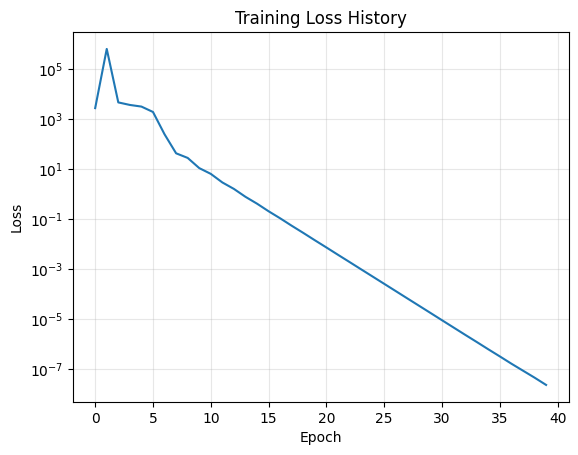

In [205]:
plt.plot([epoch for loss, epoch in hist], [loss for loss, epoch in hist])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss History')
plt.grid(True, alpha=0.3)
plt.show()